<a href="https://colab.research.google.com/github/arutraj/ML_Basics/blob/main/Live_Class___RNN_LSTM___New_York_Stock_Exchange_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New York Stock Exchange Dataset
 Most of data spans from 2010 to the end 2016, for companies new on stock market date range is shorter. There have been approx. 140 stock splits in that time, this set doesn't account for that.


The type of Neural Network designed to handle sequence dependence is called recurrent neural networks(RNN).

The Long Short-Term Memory network or LSTM network is a type of recurrent neural network used in deep learning because very large architectures can be successfully trained

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
# from tensorflow.python.keras.layers.recurrent import LSTM
from tensorflow.keras.layers import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os


In [3]:
#@title Mount Google drive for datasets access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip '/content/New York_Stock_Exchange_Dataset.zip'

Archive:  /content/New York_Stock_Exchange_Dataset.zip
  inflating: New York Stock Exchange Dataset/securities.csv  
  inflating: New York Stock Exchange Dataset/fundamentals.csv  
  inflating: New York Stock Exchange Dataset/prices-split-adjusted.csv  
  inflating: New York Stock Exchange Dataset/prices.csv  


In [7]:
#prefix_path = '/content/New York_Stock_Exchange_Dataset.zip'
data_df = pd.read_csv('/content/New York Stock Exchange Dataset/prices-split-adjusted.csv',
 index_col = 0)
data_df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


extracting the apple stocks only: AAPL

In [8]:
data_df = data_df[data_df.symbol == 'AAPL']
data_df.drop('symbol',axis=1, inplace=True)
data_df.head()

<ipython-input-8-653262c138cb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.drop('symbol',axis=1, inplace=True)


,open,close,low,high,volume
date,,,,,
2010-01-04,30.490000,30.572857,30.340000,30.642857,123432400.0
2010-01-05,30.657143,30.625713,30.464285,30.798571,150476200.0
2010-01-06,30.625713,30.138571,30.107143,30.747143,138040000.0
2010-01-07,30.250000,30.082857,29.864286,30.285715,119282800.0
2010-01-08,30.042856,30.282858,29.865715,30.285715,111902700.0


In [9]:
data_df.shape

(1762, 5)

In [10]:
data_df.tail()

,open,close,low,high,volume
date,,,,,
2016-12-23,115.589996,116.519997,115.589996,116.519997,14249500.0
2016-12-27,116.519997,117.260002,116.489998,117.800003,18296900.0
2016-12-28,117.519997,116.760002,116.199997,118.019997,20905900.0
2016-12-29,116.449997,116.730003,116.400002,117.110001,15039500.0
2016-12-30,116.650002,115.820000,115.430000,117.199997,30586300.0


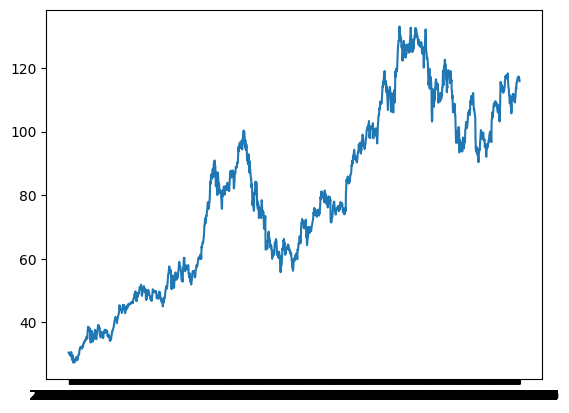

In [11]:
plt.plot(data_df['close'])
plt.show()

In [12]:
data_df['date'] = data_df.index
data_df.head()

,open,close,low,high,volume,date
date,,,,,,
2010-01-04,30.490000,30.572857,30.340000,30.642857,123432400.0,2010-01-04
2010-01-05,30.657143,30.625713,30.464285,30.798571,150476200.0,2010-01-05
2010-01-06,30.625713,30.138571,30.107143,30.747143,138040000.0,2010-01-06
2010-01-07,30.250000,30.082857,29.864286,30.285715,119282800.0,2010-01-07
2010-01-08,30.042856,30.282858,29.865715,30.285715,111902700.0,2010-01-08


In [13]:
data_df['date'] = pd.to_datetime(data_df['date'])

In [14]:
data_df.head()

,open,close,low,high,volume,date
date,,,,,,
2010-01-04,30.490000,30.572857,30.340000,30.642857,123432400.0,2010-01-04
2010-01-05,30.657143,30.625713,30.464285,30.798571,150476200.0,2010-01-05
2010-01-06,30.625713,30.138571,30.107143,30.747143,138040000.0,2010-01-06
2010-01-07,30.250000,30.082857,29.864286,30.285715,119282800.0,2010-01-07
2010-01-08,30.042856,30.282858,29.865715,30.285715,111902700.0,2010-01-08


LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing.

In [15]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(data_df['close'].values.reshape(-1, 1))

In [16]:
dataset[0:10]

array([[0.02971784],
       [0.03021854],
       [0.02560389],
       [0.02507612],
       [0.0269707 ],
       [0.02444008],
       [0.02120576],
       [0.02517085],
       [0.02351986],
       [0.0187834 ]])

In [17]:
#@title Out-of-Time split
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1233 529


In [18]:
print(len(data_df))
print(1233 + 529)

1762
1762


set the look back date as 15 days, which is the number of previous time steps to use as input variables to predict the next time period

In [19]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=15):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [20]:
x_train, y_train = create_dataset(train, look_back=15)
x_test, y_test = create_dataset(test, look_back=15)

In [21]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1217, 15)
(1217,)
(513, 15)
(513,)


The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time/sequence steps, features].

> Indented block



Currently, this data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [22]:
# x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
# x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [23]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1217, 15, 1)
(1217,)
(513, 15, 1)
(513,)


###LSTM

The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem.

As such, it can be used to create large recurrent networks that in turn can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results.

Instead of neurons, LSTM networks have memory blocks that are connected through layers.

A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence and each gate within a block uses the sigmoid activation units to control whether they are triggered or not, making the change of state and addition of information flowing through the block conditional.

There are three types of gates within a unit:

Forget Gate: conditionally decides what information to throw away from the block.
Input Gate: conditionally decides which values from the input to update the memory state.
Output Gate: conditionally decides what to output based on input and the memory of the block.
Each unit is like a mini-state machine where the gates of the units have weights that are learned during the training procedure.



> The network has a visible layer with 1 input, a hidden layer with 20 LSTM blocks or neurons, and an output layer that makes a 15 value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 20 epochs and a batch size of 1 is used.



In [24]:
#@title create and fit the LSTM network
look_back = 15
lstm_model = Sequential()
lstm_model.add(LSTM(20, input_shape=(look_back, 1)))
lstm_model.add(Dense(1)) # W_o
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

In [25]:
# lstm_model.build(input_shape=(look_back, 1))
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1781 (6.96 KB)
Trainable params: 1781 (6.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [26]:
# Train the LSTM model
lstm_model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
1217/1217 - 6s - loss: 0.0050 - 6s/epoch - 5ms/step
Epoch 2/20
1217/1217 - 5s - loss: 5.7803e-04 - 5s/epoch - 4ms/step
Epoch 3/20
1217/1217 - 6s - loss: 4.6367e-04 - 6s/epoch - 5ms/step
Epoch 4/20
1217/1217 - 5s - loss: 4.0351e-04 - 5s/epoch - 4ms/step
Epoch 5/20
1217/1217 - 5s - loss: 3.3314e-04 - 5s/epoch - 4ms/step
Epoch 6/20
1217/1217 - 6s - loss: 2.8900e-04 - 6s/epoch - 5ms/step
Epoch 7/20
1217/1217 - 5s - loss: 2.3603e-04 - 5s/epoch - 4ms/step
Epoch 8/20
1217/1217 - 5s - loss: 2.0261e-04 - 5s/epoch - 4ms/step
Epoch 9/20
1217/1217 - 6s - loss: 1.8320e-04 - 6s/epoch - 5ms/step
Epoch 10/20
1217/1217 - 4s - loss: 1.7513e-04 - 4s/epoch - 4ms/step
Epoch 11/20
1217/1217 - 6s - loss: 1.7407e-04 - 6s/epoch - 5ms/step
Epoch 12/20
1217/1217 - 6s - loss: 1.7183e-04 - 6s/epoch - 5ms/step
Epoch 13/20
1217/1217 - 4s - loss: 1.5479e-04 - 4s/epoch - 4ms/step
Epoch 14/20
1217/1217 - 5s - loss: 1.6192e-04 - 5s/epoch - 4ms/step
Epoch 15/20
1217/1217 - 7s - loss: 1.6055e-04 - 7s/epoch - 6m

In [27]:
trainPredict = lstm_model.predict(x_train)
testPredict = lstm_model.predict(x_test)
# invert predictions
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

17/17 [==============================] - 0s 3ms/step
Train Score: 1.43 RMSE
Test Score: 2.33 RMSE


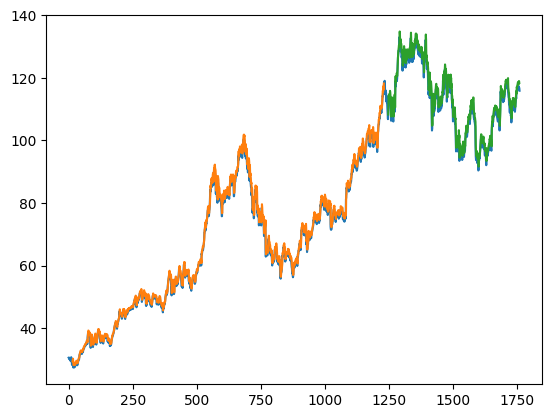

In [28]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(min_max_scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [29]:
#@title Create an FNN-like network
look_back = 15
fnn_like_model = Sequential()
fnn_like_model.add(LSTM(20, input_shape=(1, look_back))) # |h_t| = 20
fnn_like_model.add(Dense(1)) # W_o
fnn_like_model.compile(loss='mean_squared_error', optimizer='adam')

In [30]:
fnn_like_model.build((None, 1, look_back))
print(fnn_like_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20)                2880      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2901 (11.33 KB)
Trainable params: 2901 (11.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [31]:

# Train the FNN-like model
lstm_model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
1217/1217 - 7s - loss: 1.4957e-04 - 7s/epoch - 6ms/step
Epoch 2/20
1217/1217 - 6s - loss: 1.4722e-04 - 6s/epoch - 5ms/step
Epoch 3/20
1217/1217 - 5s - loss: 1.4779e-04 - 5s/epoch - 4ms/step
Epoch 4/20
1217/1217 - 5s - loss: 1.5235e-04 - 5s/epoch - 4ms/step
Epoch 5/20
1217/1217 - 6s - loss: 1.4672e-04 - 6s/epoch - 5ms/step
Epoch 6/20
1217/1217 - 5s - loss: 1.4463e-04 - 5s/epoch - 4ms/step
Epoch 7/20
1217/1217 - 5s - loss: 1.4763e-04 - 5s/epoch - 4ms/step
Epoch 8/20
1217/1217 - 6s - loss: 1.4636e-04 - 6s/epoch - 5ms/step
Epoch 9/20
1217/1217 - 5s - loss: 1.5461e-04 - 5s/epoch - 4ms/step
Epoch 10/20
1217/1217 - 5s - loss: 1.4840e-04 - 5s/epoch - 4ms/step
Epoch 11/20
1217/1217 - 6s - loss: 1.4679e-04 - 6s/epoch - 5ms/step
Epoch 12/20
1217/1217 - 4s - loss: 1.4501e-04 - 4s/epoch - 4ms/step
Epoch 13/20
1217/1217 - 7s - loss: 1.3898e-04 - 7s/epoch - 6ms/step
Epoch 14/20
1217/1217 - 6s - loss: 1.4962e-04 - 6s/epoch - 5ms/step
Epoch 15/20
1217/1217 - 5s - loss: 1.4782e-04 - 5s/epoch 

In [32]:
trainPredict = lstm_model.predict(x_train)
testPredict = lstm_model.predict(x_test)
# invert predictions
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

17/17 [==============================] - 0s 3ms/step
Train Score: 1.88 RMSE
Test Score: 2.67 RMSE


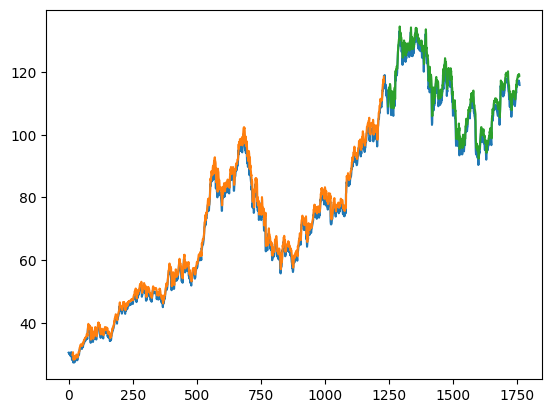

In [33]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(min_max_scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()